In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv("Loan_default.csv")
print(df.head())
print(df.describe())

       LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
0  I38PQUQS96   56   85994       50587          520              80   
1  HPSK72WA7R   69   50432      124440          458              15   
2  C1OZ6DPJ8Y   46   84208      129188          451              26   
3  V2KKSFM3UN   32   31713       44799          743               0   
4  EY08JDHTZP   60   20437        9139          633               8   

   NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
0               4         15.23        36      0.44   Bachelor's   
1               1          4.81        60      0.68     Master's   
2               3         21.17        24      0.31     Master's   
3               3          7.07        24      0.23  High School   
4               4          6.51        48      0.73   Bachelor's   

  EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpose  \
0      Full-time      Divorced         Yes           Yes       Other   
1      Full-time    

In [2]:
df=pd.read_csv("Loan_Default.csv")
print(df.tail())
print(df.isnull())
print(df.sum)
print(df.shape) 
print(df.columns)  

            LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
255342  8C6S86ESGC   19   37979      210682          541             109   
255343  98R4KDHNND   32   51953      189899          511              14   
255344  XQK1UUUNGP   56   84820      208294          597              70   
255345  JAO28CPL4H   42   85109       60575          809              40   
255346  ZTH91CGL0B   62   22418       18481          636             113   

        NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
255342               4         14.11        12      0.85   Bachelor's   
255343               2         11.55        24      0.21  High School   
255344               3          5.29        60      0.50  High School   
255345               1         20.90        48      0.44  High School   
255346               2          6.73        12      0.48   Bachelor's   

       EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpose  \
255342      Full-time      

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import joblib
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

os.makedirs("models", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

In [4]:
df = pd.read_csv("Loan_Default.csv")
print("Shape:", df.shape)
display(df.head())
display(df.describe(include='all').T)
if 'LoanID' in df.columns:
    df = df.drop(columns=['LoanID'])

print("Columns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isnull().sum())
print("\nTarget distribution:\n", df['Default'].value_counts(normalize=True).rename('proportion'))

Shape: (255347, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
LoanID,255347,255347,I38PQUQS96,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,255347.0,NaN,NaN,NaN,43.498306,14.990258,18.0,31.0,43.0,56.0,69.0
Income,255347.0,NaN,NaN,NaN,82499.304597,38963.013729,15000.0,48825.5,82466.0,116219.0,149999.0
LoanAmount,255347.0,NaN,NaN,NaN,127578.865512,70840.706142,5000.0,66156.0,127556.0,188985.0,249999.0
CreditScore,255347.0,NaN,NaN,NaN,574.264346,158.903867,300.0,437.0,574.0,712.0,849.0
MonthsEmployed,255347.0,NaN,NaN,NaN,59.541976,34.643376,0.0,30.0,60.0,90.0,119.0
NumCreditLines,255347.0,NaN,NaN,NaN,2.501036,1.117018,1.0,2.0,2.0,3.0,4.0
InterestRate,255347.0,NaN,NaN,NaN,13.492773,6.636443,2.0,7.77,13.46,19.25,25.0
LoanTerm,255347.0,NaN,NaN,NaN,36.025894,16.96933,12.0,24.0,36.0,48.0,60.0
DTIRatio,255347.0,NaN,NaN,NaN,0.500212,0.230917,0.1,0.3,0.5,0.7,0.9


Columns: ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner', 'Default']

Missing values per column:
 Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

Target distribution:
 Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64


In [5]:
X = df.drop(columns=['Default'])
y = df['Default'].astype(int)

numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
Categorical columns: ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']


In [6]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_cols),
    ('cat', cat_pipeline, categorical_cols)
], remainder='drop')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (204277, 16) Test: (51070, 16)


In [7]:
def make_pipeline_with_smote(estimator):
    return ImbPipeline([
        ('pre', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', estimator)
    ])
models = {
    "LogisticRegression": make_pipeline_with_smote(LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    "NaiveBayes": make_pipeline_with_smote(GaussianNB()),
    "DecisionTree": make_pipeline_with_smote(DecisionTreeClassifier(random_state=RANDOM_STATE)),
    #"RandomForest": make_pipeline_with_smote(RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)),
    "KNN": make_pipeline_with_smote(KNeighborsClassifier(n_neighbors=5)),
    "XGBoost": make_pipeline_with_smote(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE))
}

for name, pipe in models.items():
    print(name, "->", pipe)

LogisticRegression -> Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Income',
                                                   'LoanAmount', 'CreditScore',
                                                   'MonthsEmployed',
                                                   'NumCreditLines',
                                                   'InterestRate', 'LoanTerm',
                                                   'DTIRatio']),
                                                 ('cat',
                                                  Pipeline(steps=

In [8]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

baseline_results = []
for name, pipe in models.items():
    print(f"Running CV for {name} ...")
    acc_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    try:
        auc_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    except Exception:
        auc_scores = np.array([np.nan]*cv.get_n_splits())
    baseline_results.append({
        'model': name,
        'accuracy_mean': acc_scores.mean(),
        'accuracy_std': acc_scores.std(),
        'roc_auc_mean': np.nanmean(auc_scores),
        'roc_auc_std': np.nanstd(auc_scores)
    })

baseline_df = pd.DataFrame(baseline_results).sort_values('roc_auc_mean', ascending=False)
display(baseline_df)

Running CV for LogisticRegression ...
Running CV for NaiveBayes ...
Running CV for DecisionTree ...
Running CV for KNN ...
Running CV for XGBoost ...


,model,accuracy_mean,accuracy_std,roc_auc_mean,roc_auc_std
0,LogisticRegression,0.681976,0.002131,0.746259,0.001323
4,XGBoost,0.883937,0.001036,0.737608,0.002212
1,NaiveBayes,0.694077,0.000665,0.731258,0.002260
3,KNN,0.650646,0.002034,0.624786,0.003398
2,DecisionTree,0.772828,0.002640,0.558603,0.001399


In [9]:
top_model_name = baseline_df.sort_values('roc_auc_mean', ascending=False).iloc[0]['model']
print("Top candidate:", top_model_name)

best_pipeline = models[top_model_name]
best_pipeline.fit(X_train, y_train)

y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:,1] if hasattr(best_pipeline, "predict_proba") else None

print("Test Accuracy:", accuracy_score(y_test, y_pred))
if y_proba is not None:
    print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Top candidate: LogisticRegression
Test Accuracy: 0.6828470726453887
Test ROC AUC: 0.7531299495734356

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.68      0.79     45139
           1       0.22      0.69      0.34      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.68      0.74     51070


Confusion matrix:
 [[30770 14369]
 [ 1828  4103]]


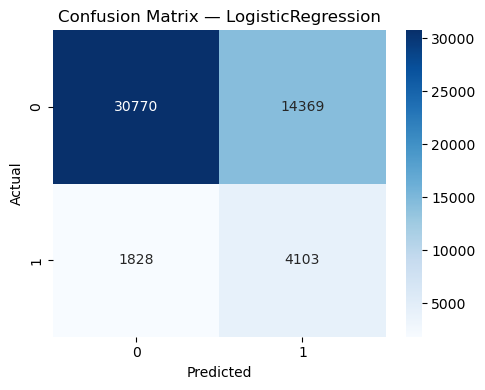

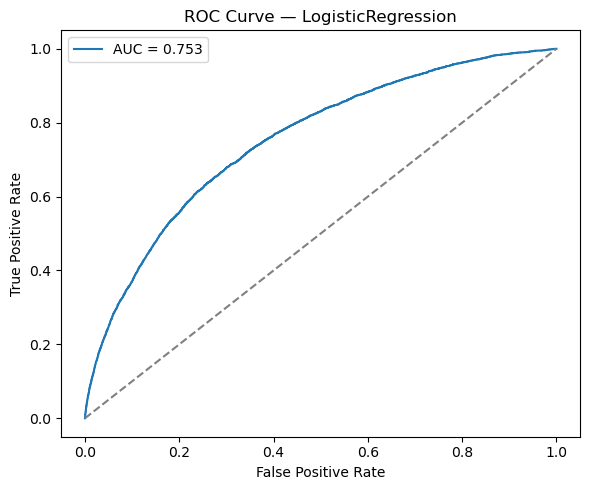

In [10]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix — {top_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(f"outputs/confusion_matrix_{top_model_name}.png")
plt.show()

if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve — {top_model_name}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"outputs/roc_{top_model_name}.png")
    plt.show()

In [11]:
from sklearn.model_selection import RandomizedSearchCV

def get_base_model(top_model_name):

    if top_model_name == 'XGBoost':
        return XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=RANDOM_STATE
        )

    elif top_model_name == 'DecisionTree':
        return DecisionTreeClassifier(random_state=RANDOM_STATE)

    elif top_model_name == 'LogisticRegression':
        return LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)

    else:
        raise ValueError("Unsupported model for tuning!")


base_model = get_base_model(top_model_name)
search_pipeline = make_pipeline_with_smote(base_model)

if top_model_name == 'XGBoost':
    param_dist = {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 5, 7],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__subsample': [0.6, 0.8, 1.0]
    }

elif top_model_name == 'DecisionTree':
    param_dist = {
        'clf__max_depth': [None, 8, 12, 20],
        'clf__min_samples_split': [2, 5, 10]
    }

elif top_model_name == 'LogisticRegression':
    param_dist = {
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    }

print(f"Running RandomizedSearchCV for {top_model_name}")

search = RandomizedSearchCV(
    estimator=search_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV ROC AUC:", search.best_score_)

best_pipeline = search.best_estimator_

y_pred = best_pipeline.predict(X_test)

if hasattr(best_pipeline, "predict_proba"):
    y_proba = best_pipeline.predict_proba(X_test)[:, 1]
else:
    y_proba = None

print("\nTuned Test Accuracy:", accuracy_score(y_test, y_pred))

if y_proba is not None:
    print("Tuned Test ROC AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Running RandomizedSearchCV for LogisticRegression
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__C': 0.01}
Best CV ROC AUC: 0.7463370055636634

Tuned Test Accuracy: 0.6828666536126885
Tuned Test ROC AUC: 0.753134663464015

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.68      0.79     45139
           1       0.22      0.69      0.34      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.68      0.74     51070



In [12]:
joblib.dump(best_pipeline, "models/final_pipeline.pkl")
print("Saved pipeline to models/final_pipeline.pkl")
preprocessor.fit(X)
joblib.dump(preprocessor, "models/preprocessor.pkl")
print("Saved preprocessor to models/preprocessor.pkl")

Saved pipeline to models/final_pipeline.pkl
Saved preprocessor to models/preprocessor.pkl


In [13]:
loaded = joblib.load("models/final_pipeline.pkl")
sample = X_test.iloc[0:3].to_dict(orient='records')  
sample_df = pd.DataFrame(sample)
preds = loaded.predict(sample_df)
probs = loaded.predict_proba(sample_df)[:,1] if hasattr(loaded, "predict_proba") else None
print("Sample inputs:\n", sample_df)
print("Predictions:", preds)
print("Probabilities:", probs)

Sample inputs:
    Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
0   54   20956       87156          789             102               4   
1   49  138499      227279          603             102               4   
2   69   22538       48532          337              48               2   

   InterestRate  LoanTerm  DTIRatio    Education EmploymentType MaritalStatus  \
0          8.99        24      0.65     Master's      Full-time        Single   
1          2.46        12      0.67  High School      Full-time       Married   
2         16.15        24      0.74  High School  Self-employed      Divorced   

  HasMortgage HasDependents LoanPurpose HasCoSigner  
0         Yes           Yes   Education          No  
1         Yes            No        Home          No  
2         Yes           Yes       Other          No  
Predictions: [0 0 0]
Probabilities: [0.15679072 0.11375134 0.36427723]


In [32]:
def make_pipeline(model):
    return ImbPipeline([
        ("pre", preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("model", model)
    ])

models = {
    "Logistic Regression": make_pipeline(LogisticRegression(max_iter=1000)),
    "Naive Bayes": make_pipeline(GaussianNB()),
    "Decision Tree": make_pipeline(DecisionTreeClassifier(random_state=42)),
    #"Random Forest": make_pipeline(RandomForestClassifier(n_estimators=200, random_state=42)),
    "KNN": make_pipeline(KNeighborsClassifier(n_neighbors=5)),
    "XGBoost": make_pipeline(XGBClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=5,
        subsample=0.7, colsample_bytree=0.8, eval_metric="logloss",
        random_state=42
    ))
}

In [34]:
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

stack_estimators = [
    ('gb', GradientBoostingClassifier(n_estimators=120, random_state=42)),
    ('lr', LogisticRegression(max_iter=500)),
    ('nb', GaussianNB()),
    ('dt', DecisionTreeClassifier(max_depth=6, random_state=42))
]


stack_model = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=LogisticRegression(max_iter=500),
    n_jobs=1,   
    cv=3             
)

models["STACKING"] = Pipeline([
    ('pre', preprocessor), 
    ('stack', stack_model)
])

In [36]:
results = {}
probas = {}
predictions = {}
trained_models = {}

for name, model in models.items():
    print("Training:", name)
    
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    predictions[name] = y_pred
    probas[name] = y_proba
    
    acc = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    
    results[name] = {"accuracy": acc, "auc": auc_score}
    
    print("Accuracy:", acc)
    print("AUC:", auc_score)
    print(classification_report(y_test, y_pred))

Training: Logistic Regression
Accuracy: 0.6828470726453887
AUC: 0.7531299495734356
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     45139
           1       0.22      0.69      0.34      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.68      0.74     51070

Training: Naive Bayes
Accuracy: 0.6914431172899941
AUC: 0.7384672621924098
              precision    recall  f1-score   support

           0       0.94      0.70      0.80     45139
           1       0.22      0.66      0.33      5931

    accuracy                           0.69     51070
   macro avg       0.58      0.68      0.57     51070
weighted avg       0.86      0.69      0.75     51070

Training: Decision Tree
Accuracy: 0.7742901899353828
AUC: 0.5613993660803278
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     45139
  

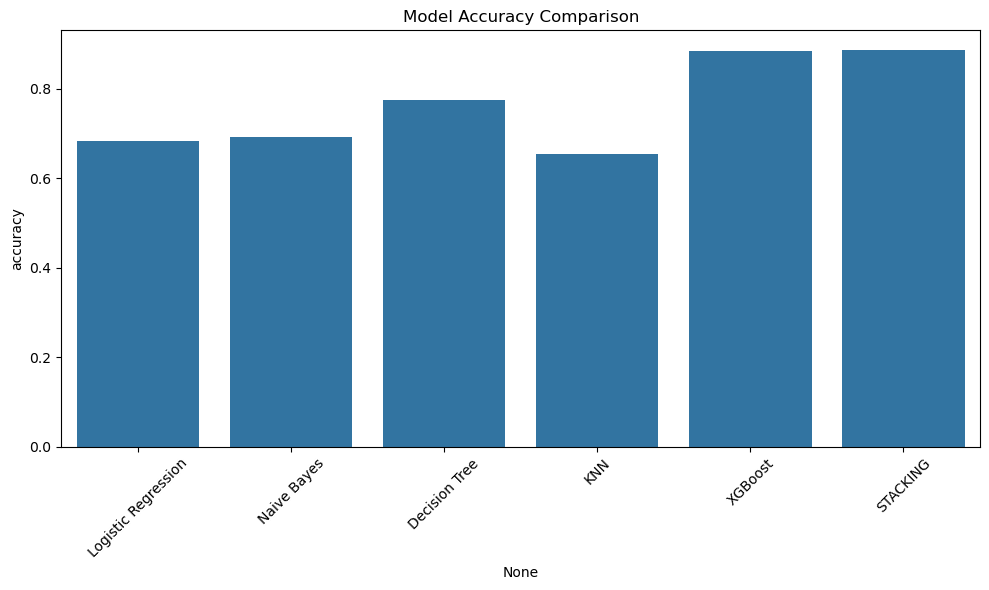

In [38]:
res_df = pd.DataFrame(results).T
plt.figure(figsize=(10,6))
sns.barplot(x=res_df.index, y=res_df["accuracy"])
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison")
plt.tight_layout()
plt.show()

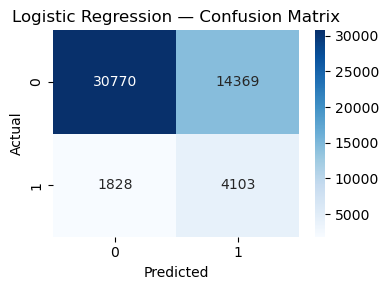

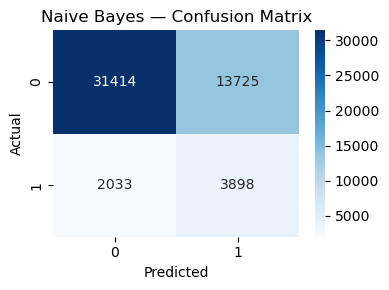

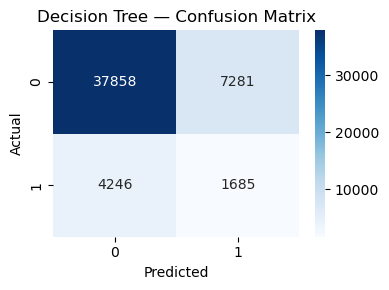

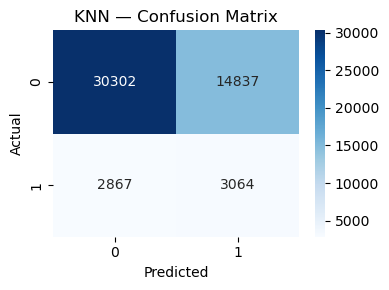

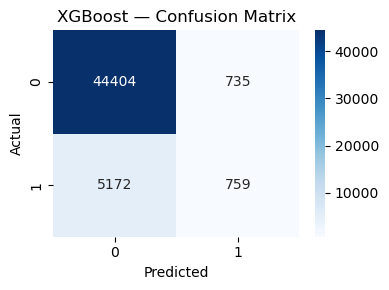

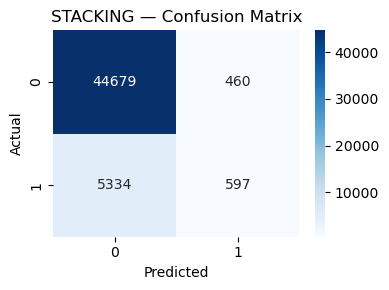

In [40]:
for name in models.keys():
    cm = confusion_matrix(y_test, predictions[name])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

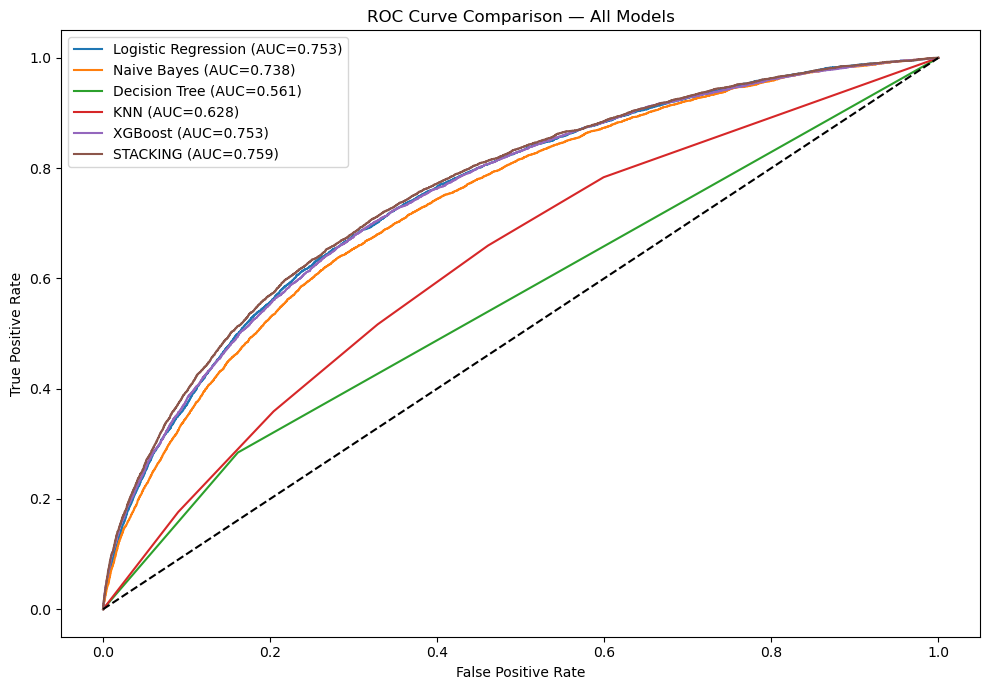

In [42]:
plt.figure(figsize=(10,7))

for name in models.keys():
    fpr, tpr, _ = roc_curve(y_test, probas[name])
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison — All Models")
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
tree_based = ["Random Forest", "Decision Tree", "XGBoost"]

for name in tree_based:
    try:
        model = trained_models[name].named_steps["model"]
        importances = model.feature_importances_
        
        # get transformed feature names
        ohe = trained_models[name].named_steps["pre"].named_transformers_["cat"]["onehot"]
        cat_names = ohe.get_feature_names_out(categorical_cols)
        feature_names = list(numeric_cols) + list(cat_names)
        
        fi = pd.DataFrame({"feature": feature_names, "importance": importances})
        fi = fi.sort_values("importance", ascending=False).head(20)
        
        plt.figure(figsize=(8,6))
        sns.barplot(y=fi["feature"], x=fi["importance"])
        plt.title(f"{name} — Feature Importance")
        plt.tight_layout()
        plt.show()
        
    except:
        pass

In [52]:
best_model_name = res_df["auc"].idxmax()
best_model = trained_models[best_model_name]

print("Best Model:", best_model_name)
joblib.dump(best_model, "models/final_pipeline.pkl")
best_model

Best Model: STACKING


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Income',
                                                   'LoanAmount', 'CreditScore',
                                                   'MonthsEmployed',
                                                   'NumCreditLines',
                                                   'InterestRate', 'LoanTerm',
                                                   'DTIRatio']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe'...
                                                   'HasMortgage',
                                                   'HasDependents',
                                                   'LoanPurpose',
                                                   'HasCoSigner'])])),
                ('stack',
                 StackingClassifier(cv=3,
                                    estimators=[('gb',
                                                 GradientBoostingClassifier(n_estimators=120,
                                                                            random_state=42)),
                                                ('lr',
                                                 LogisticRegression(max_iter=500)),
                                                ('nb', GaussianNB()),
                                                ('dt',
                                                 DecisionTreeClassifier(max_depth=6,
                                                                        random_state=42))],
                                    final_estimator=LogisticRegression(max_iter=500),
                                    n_jobs=1))])

In [48]:
loaded = joblib.load("models/final_pipeline.pkl")

sample = X_test.iloc[0:3].to_dict(orient='records')
sample_df = pd.DataFrame(sample)

preds = loaded.predict(sample_df)
probs = loaded.predict_proba(sample_df)[:,1]

print("Sample Input:")
print(sample_df)
print("Predictions:", preds)
print("Probabilities:", probs)

Sample Input:
   Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
0   54   20956       87156          789             102               4   
1   49  138499      227279          603             102               4   
2   69   22538       48532          337              48               2   

   InterestRate  LoanTerm  DTIRatio    Education EmploymentType MaritalStatus  \
0          8.99        24      0.65     Master's      Full-time        Single   
1          2.46        12      0.67  High School      Full-time       Married   
2         16.15        24      0.74  High School  Self-employed      Divorced   

  HasMortgage HasDependents LoanPurpose HasCoSigner  
0         Yes           Yes   Education          No  
1         Yes            No        Home          No  
2         Yes           Yes       Other          No  
Predictions: [0 0 0]
Probabilities: [0.0562282  0.04963809 0.06771891]


In [50]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def get_metrics(model, X_train, y_train, X_test, y_test):

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_train, train_pred).ravel()
    tn_ts, fp_ts, fn_ts, tp_ts = confusion_matrix(y_test, test_pred).ravel()

    metrics = {
        "Train Accuracy": accuracy_score(y_train, train_pred) * 100,
        "Train Sensitivity": recall_score(y_train, train_pred) * 100,
        "Train Specificity": (tn_tr / (tn_tr + fp_tr)) * 100,
        "Train Precision": precision_score(y_train, train_pred) * 100,
        "Train F1": f1_score(y_train, train_pred) * 100,

        "Test Accuracy": accuracy_score(y_test, test_pred) * 100,
        "Test Sensitivity": recall_score(y_test, test_pred) * 100,
        "Test Specificity": (tn_ts / (tn_ts + fp_ts)) * 100,
        "Test Precision": precision_score(y_test, test_pred) * 100,
        "Test F1": f1_score(y_test, test_pred) * 100,
    }

    return metrics

summary = []

for name, model in trained_models.items():
    print(f"Evaluating: {name}")
    m = get_metrics(model, X_train, y_train, X_test, y_test)
    m["Model"] = name
    summary.append(m)

summary_df = pd.DataFrame(summary)
summary_df = summary_df[
    ["Model",
     "Train Accuracy", "Train Sensitivity", "Train Specificity", "Train Precision", "Train F1",
     "Test Accuracy", "Test Sensitivity", "Test Specificity", "Test Precision", "Test F1"]
]

summary_df

Evaluating: Logistic Regression
Evaluating: Naive Bayes
Evaluating: Decision Tree
Evaluating: KNN
Evaluating: XGBoost
Evaluating: STACKING


,Model,Train Accuracy,Train Sensitivity,Train Specificity,Train Precision,Train F1,Test Accuracy,Test Sensitivity,Test Specificity,Test Precision,Test F1
0,Logistic Regression,68.156963,68.021246,68.174794,21.924509,33.160707,68.284707,69.178891,68.167217,22.211997,33.627013
1,Naive Bayes,69.090989,64.126128,69.743292,21.780590,32.516780,69.144312,65.722475,69.593921,22.118822,33.098412
2,Decision Tree,100.000000,100.000000,100.000000,100.000000,100.000000,77.429019,28.410049,83.869824,18.793219,22.622004
3,KNN,79.315831,99.865104,76.615990,35.942407,52.859996,65.333855,51.660765,67.130419,17.116362,25.713327
4,XGBoost,88.460277,12.385128,98.455318,51.300856,19.953139,88.433523,12.797167,98.371696,50.803213,20.444444
5,STACKING,88.625739,9.855830,98.974828,55.812843,16.753251,88.654788,10.065756,98.980926,56.480605,17.086434
